In [512]:
# Import necessary libraries
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting

import seaborn as sns


import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VECM
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from statsmodels.stats.stattools import jarque_bera

from scipy.stats import norm

from IPython.display import Markdown

import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings("ignore")

In [513]:
# Adjust path relative to the notebook location
file_path = 'data/TSA_2025_project_data_1.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [514]:
train_df = df.iloc[:575]
test_df = df.iloc[575:]

In [515]:
print(df.columns)

Index(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10'], dtype='object')


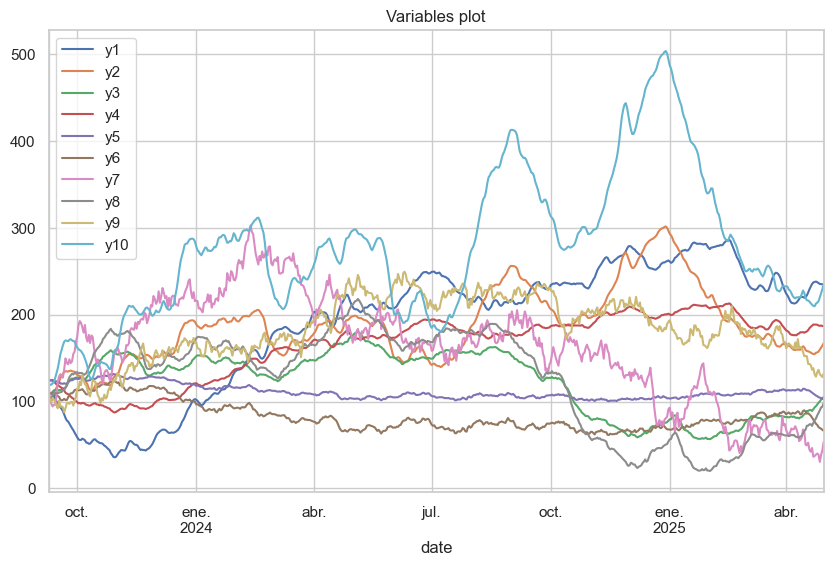

In [516]:
df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].plot(figsize=(10, 6), title="Variables plot")
plt.show()

With no test yet we can appreciete a similar tendency on the variables [y2 and y10], [y3 and y8] and [y5 and y6] 

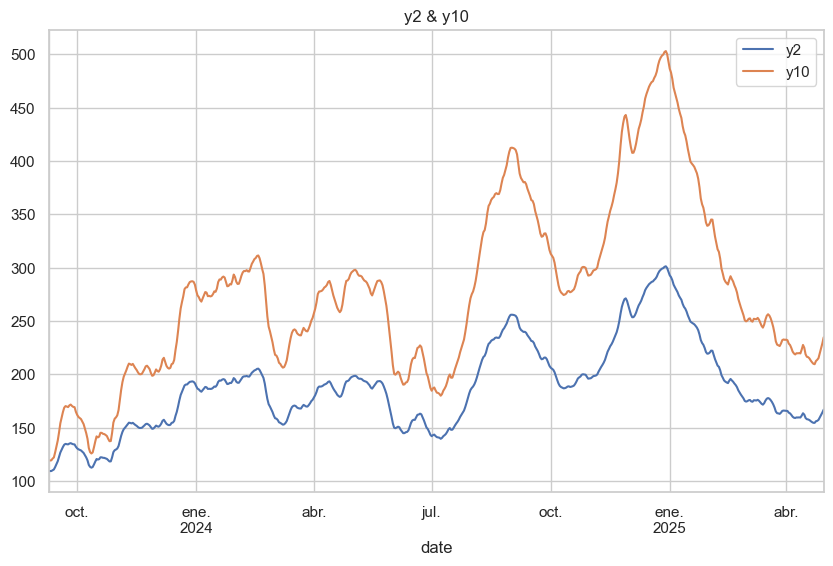

In [517]:
df[['y2','y10']].plot(figsize=(10, 6), title="y2 & y10")
plt.show()

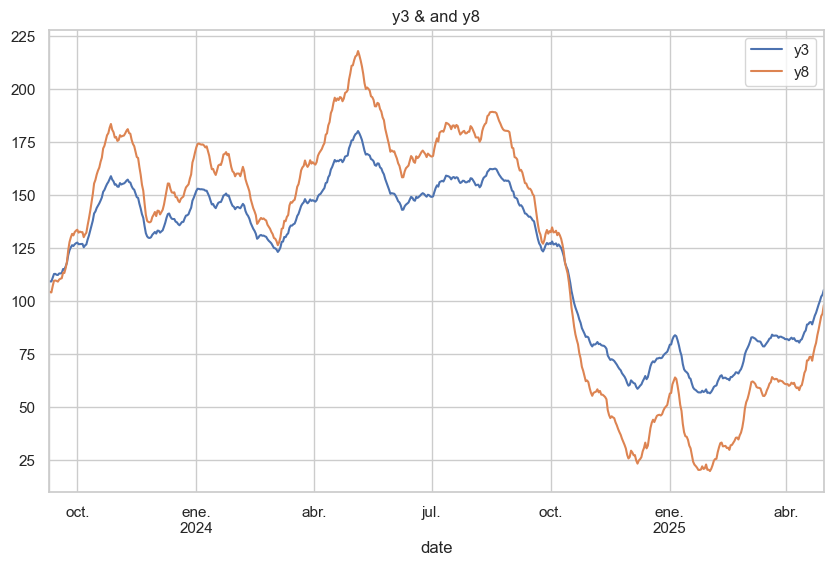

In [518]:
df[['y3', 'y8']].plot(figsize=(10, 6), title="y3 & and y8")
plt.show()

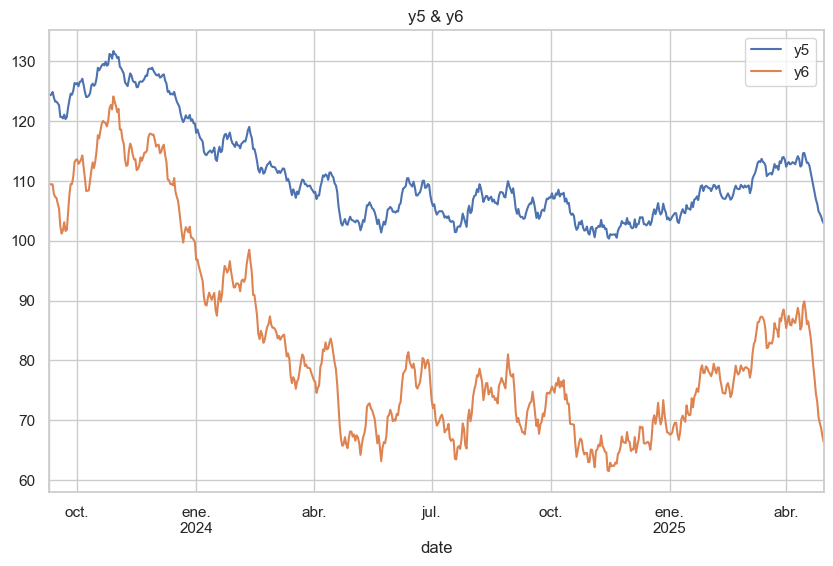

In [519]:
df[['y5', 'y6']].plot(figsize=(10, 6), title="y5 & y6")
plt.show()

In [520]:
diff_df = train_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].diff()

for col in diff_df.columns:
    train_df[f'd{col}'] = diff_df[col]

In [521]:
train_df.head()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,dy1,dy2,dy3,dy4,dy5,dy6,dy7,dy8,dy9,dy10
date,,,,,,,,,,,,,,,,,,,,
2023-09-09,109.4100000000,109.4100000000,109.4100000000,124.2400000000,124.4700000000,109.4100000000,119.9400000000,104.6600000000,107.6200000000,119.3200000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-10,109.4100000000,109.4100000000,109.4100000000,124.2100000000,124.3200000000,109.4100000000,101.3900000000,104.3400000000,102.6100000000,119.3600000000,0.0000000000,0.0000000000,0.0000000000,-0.0300000000,-0.1500000000,0.0000000000,-18.5500000000,-0.3200000000,-5.0100000000,0.0400000000
2023-09-11,109.4200000000,109.4100000000,109.4100000000,124.4100000000,124.3700000000,109.4100000000,97.6400000000,104.2300000000,99.1600000000,119.3800000000,0.0100000000,0.0000000000,0.0000000000,0.2000000000,0.0500000000,0.0000000000,-3.7500000000,-0.1100000000,-3.4500000000,0.0200000000
2023-09-12,108.6800000000,110.1900000000,111.1200000000,123.9300000000,124.8200000000,109.4100000000,94.3500000000,107.2300000000,103.3900000000,121.0600000000,-0.7400000000,0.7800000000,1.7100000000,-0.4800000000,0.4500000000,0.0000000000,-3.2900000000,3.0000000000,4.2300000000,1.6800000000
2023-09-13,106.2100000000,110.8800000000,112.9200000000,122.6800000000,123.9100000000,107.8400000000,96.2200000000,109.7100000000,102.4300000000,122.1700000000,-2.4700000000,0.6900000000,1.8000000000,-1.2500000000,-0.9100000000,-1.5700000000,1.8700000000,2.4800000000,-0.9600000000,1.1100000000


## 1. Test for Cointegration

In [522]:
def adf_test(series, max_lag=5):
    result = adfuller(series.dropna(), maxlag=max_lag, autolag=None)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [523]:
X = train_df["y2"].values
adf_test(df["y2"])

ADF Statistic: -2.384781
p-value: 0.146078
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


In [524]:
X = train_df["y10"].values
adf_test(train_df["y10"])

ADF Statistic: -2.250023
p-value: 0.188593
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


In [525]:
X = train_df["dy2"].values
adf_test(train_df["dy2"])

ADF Statistic: -6.574744
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject Ho - Time Series is Stationary


In [526]:
X = train_df["dy10"].values
adf_test(train_df["dy10"])

ADF Statistic: -6.511367
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject Ho - Time Series is Stationary


Both variables are $\sim I(1)$, so in the next step we can check whether they are **cointegrated**.

In [527]:
def adf_test(series, max_aug=10, version='c'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4); 
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4); 
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10, 
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)', 
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)', 
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)', 
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']
    
    return results_df

In [528]:
adf_test(train_df['y2'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8822597171,-3.4340000000,-2.8630000000,-2.5680000000,425.7181000000,0.0000000000,449.7069000000,0.0000000000,452.5615000000,0.0000000000,453.1616000000,0.0000000000
1,1,-2.6157603140,-3.4340000000,-2.8630000000,-2.5680000000,47.3642000000,0.0000000000,97.9047000000,0.0000000000,102.8077000000,0.0000000000,104.6629000000,0.0000000000
2,2,-2.1496364941,-3.4340000000,-2.8630000000,-2.5680000000,26.6086000000,0.0000000000,57.3745000000,0.0000000000,60.4578000000,0.0000000000,62.2334000000,0.0000000000
3,3,-2.4049360991,-3.4340000000,-2.8630000000,-2.5680000000,12.3845000000,0.0004000000,33.3642000000,0.0000000000,38.7658000000,0.0000000000,40.0410000000,0.0004000000
4,4,-2.1935056626,-3.4340000000,-2.8630000000,-2.5680000000,12.8349000000,0.0003000000,25.2678000000,0.0001000000,30.1459000000,0.0008000000,31.6027000000,0.0073000000
5,5,-2.2673831114,-3.4340000000,-2.8630000000,-2.5680000000,5.9263000000,0.0149000000,12.6567000000,0.0268000000,16.7567000000,0.0799000000,17.6630000000,0.2808000000
6,6,-2.0950562734,-3.4340000000,-2.8630000000,-2.5680000000,2.4646000000,0.1164000000,3.1010000000,0.6844000000,8.1404000000,0.6151000000,9.6346000000,0.8421000000
7,7,-2.1268162270,-3.4340000000,-2.8630000000,-2.5680000000,0.0088000000,0.9254000000,4.4085000000,0.4922000000,6.5432000000,0.7677000000,8.2050000000,0.9153000000
8,8,-2.0161896703,-3.4340000000,-2.8630000000,-2.5680000000,0.0003000000,0.9869000000,0.2940000000,0.9978000000,8.5821000000,0.5722000000,10.2659000000,0.8027000000
9,9,-2.0628662544,-3.4340000000,-2.8630000000,-2.5680000000,0.7748000000,0.3787000000,4.3188000000,0.5045000000,6.0732000000,0.8091000000,9.5162000000,0.8490000000


In [529]:
adf_test(train_df['y10'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8841970367,-3.4340000000,-2.8630000000,-2.5680000000,424.8320000000,0.0000000000,446.6175000000,0.0000000000,448.9251000000,0.0000000000,449.7937000000,0.0000000000
1,1,-2.6105197595,-3.4340000000,-2.8630000000,-2.5680000000,44.9137000000,0.0000000000,87.3367000000,0.0000000000,91.9624000000,0.0000000000,94.8094000000,0.0000000000
2,2,-2.1572125995,-3.4340000000,-2.8630000000,-2.5680000000,23.4591000000,0.0000000000,47.4175000000,0.0000000000,51.3834000000,0.0000000000,54.0694000000,0.0000000000
3,3,-2.3880321292,-3.4340000000,-2.8630000000,-2.5680000000,10.0651000000,0.0015000000,26.0485000000,0.0001000000,33.1850000000,0.0003000000,35.2355000000,0.0023000000
4,4,-2.2158434286,-3.4340000000,-2.8630000000,-2.5680000000,11.4985000000,0.0007000000,20.5542000000,0.0010000000,27.1344000000,0.0025000000,29.5367000000,0.0137000000
5,5,-2.2500225144,-3.4340000000,-2.8630000000,-2.5680000000,4.5137000000,0.0336000000,9.3863000000,0.0946000000,14.2728000000,0.1609000000,16.4127000000,0.3552000000
6,6,-2.1211851993,-3.4340000000,-2.8630000000,-2.5680000000,1.4136000000,0.2345000000,2.0948000000,0.8359000000,8.5889000000,0.5715000000,11.1112000000,0.7447000000
7,7,-2.1000681212,-3.4340000000,-2.8630000000,-2.5680000000,0.2525000000,0.6153000000,4.1009000000,0.5350000000,8.0809000000,0.6209000000,11.1190000000,0.7441000000
8,8,-2.0400696030,-3.4340000000,-2.8630000000,-2.5680000000,0.7993000000,0.3713000000,1.5940000000,0.9020000000,9.9952000000,0.4409000000,13.3483000000,0.5754000000
9,9,-2.0439985379,-3.4340000000,-2.8630000000,-2.5680000000,0.3369000000,0.5616000000,4.3649000000,0.4982000000,7.0440000000,0.7213000000,12.7791000000,0.6194000000


In [530]:
adf_test(train_df['dy2'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5264261015,-3.4340000000,-2.8630000000,-2.5680000000,49.4348000000,0.0000000000,99.4710000000,0.0000000000,103.8406000000,0.0000000000,105.6099000000,0.0000000000
1,1,-8.5108319450,-3.4340000000,-2.8630000000,-2.5680000000,25.1371000000,0.0000000000,56.5251000000,0.0000000000,60.2453000000,0.0000000000,61.8927000000,0.0000000000
2,2,-6.4547703190,-3.4340000000,-2.8630000000,-2.5680000000,13.2432000000,0.0003000000,34.6242000000,0.0000000000,39.2896000000,0.0000000000,40.3723000000,0.0004000000
3,3,-7.2512492577,-3.4340000000,-2.8630000000,-2.5680000000,11.4218000000,0.0007000000,22.4273000000,0.0004000000,28.7420000000,0.0014000000,31.1664000000,0.0083000000
4,4,-6.0530363178,-3.4340000000,-2.8630000000,-2.5680000000,5.8534000000,0.0155000000,13.4716000000,0.0193000000,16.9595000000,0.0753000000,17.6737000000,0.2802000000
5,5,-6.5747441997,-3.4340000000,-2.8630000000,-2.5680000000,1.9583000000,0.1617000000,3.0217000000,0.6966000000,7.6603000000,0.6620000000,8.9673000000,0.8792000000
6,6,-5.9884128035,-3.4340000000,-2.8630000000,-2.5680000000,0.0331000000,0.8557000000,4.5996000000,0.4667000000,6.3734000000,0.7830000000,7.6892000000,0.9356000000
7,7,-5.9705493783,-3.4340000000,-2.8630000000,-2.5680000000,0.0100000000,0.9202000000,0.2143000000,0.9990000000,7.7447000000,0.6538000000,9.3393000000,0.8591000000
8,8,-5.5150496553,-3.4340000000,-2.8630000000,-2.5680000000,0.3905000000,0.5320000000,4.0894000000,0.5366000000,5.3505000000,0.8666000000,8.0173000000,0.9231000000
9,9,-5.0597388737,-3.4340000000,-2.8630000000,-2.5680000000,0.8463000000,0.3576000000,2.4249000000,0.7878000000,4.0264000000,0.9461000000,6.0733000000,0.9785000000


In [531]:
adf_test(train_df['dy10'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5498339355,-3.4340000000,-2.8630000000,-2.5680000000,46.9409000000,0.0000000000,88.8667000000,0.0000000000,92.9935000000,0.0000000000,95.7079000000,0.0000000000
1,1,-8.4691134007,-3.4340000000,-2.8630000000,-2.5680000000,22.0677000000,0.0000000000,46.3786000000,0.0000000000,51.0895000000,0.0000000000,53.4932000000,0.0000000000
2,2,-6.5175642444,-3.4340000000,-2.8630000000,-2.5680000000,10.8611000000,0.0010000000,27.2425000000,0.0001000000,33.6782000000,0.0002000000,35.5019000000,0.0021000000
3,3,-7.2005973366,-3.4340000000,-2.8630000000,-2.5680000000,10.1311000000,0.0015000000,19.0368000000,0.0019000000,24.3167000000,0.0068000000,29.3831000000,0.0144000000
4,4,-6.1030210775,-3.4340000000,-2.8630000000,-2.5680000000,4.3882000000,0.0362000000,10.1735000000,0.0705000000,14.5389000000,0.1498000000,16.4982000000,0.3497000000
5,5,-6.5113665233,-3.4340000000,-2.8630000000,-2.5680000000,1.0206000000,0.3124000000,2.1472000000,0.8284000000,8.1432000000,0.6148000000,10.5545000000,0.7835000000
6,6,-6.0714771785,-3.4340000000,-2.8630000000,-2.5680000000,0.3530000000,0.5524000000,4.3293000000,0.5030000000,7.7331000000,0.6549000000,10.3859000000,0.7948000000
7,7,-5.9345210003,-3.4340000000,-2.8630000000,-2.5680000000,0.7358000000,0.3910000000,1.5559000000,0.9065000000,9.2835000000,0.5054000000,12.5279000000,0.6387000000
8,8,-5.5690146782,-3.4340000000,-2.8630000000,-2.5680000000,0.0832000000,0.7730000000,5.0274000000,0.4125000000,5.9377000000,0.8205000000,11.0986000000,0.7456000000
9,9,-5.0118793968,-3.4340000000,-2.8630000000,-2.5680000000,1.5562000000,0.2122000000,3.6003000000,0.6083000000,6.1205000000,0.8050000000,7.4279000000,0.9447000000


Once again we can see that the variables are integrated of order 1, no autocorrelation in residuals from 5 augmentations

To estimating the cointegrating vector, we will estimate the following model:

In [532]:
model_coint = OLS(train_df['y2'], np.column_stack((np.ones(len(train_df)), train_df['y10']))).fit()

In [533]:
print(model_coint.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.386e+08
Date:               sá., 24 may. 2025   Prob (F-statistic):               0.00
Time:                        21:43:00   Log-Likelihood:                 924.52
No. Observations:                 575   AIC:                            -1845.
Df Residuals:                     573   BIC:                            -1836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.6951      0.007   7134.319      0.0

In [534]:
beta = model_coint.params
print(f"beta.const: {beta.const:.4f}")

beta.const: 49.6951


In [535]:
# Test stationarity of residuals
residuals = model_coint.resid
adf_test(pd.Series(residuals))

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.0445796757,-3.4340000000,-2.8630000000,-2.5680000000,0.2826000000,0.5950000000,4.7958000000,0.4413000000,7.1766000000,0.7087000000,14.6780000000,0.4749000000
1,1,-16.2518209716,-3.4340000000,-2.8630000000,-2.5680000000,0.3555000000,0.5510000000,4.4236000000,0.4902000000,6.6004000000,0.7626000000,14.5325000000,0.4856000000
2,2,-13.9834050589,-3.4340000000,-2.8630000000,-2.5680000000,-1.6957000000,1.0000000000,6.2373000000,0.2838000000,9.8001000000,0.4582000000,17.0236000000,0.3175000000
3,3,-12.7346917455,-3.4340000000,-2.8630000000,-2.5680000000,-3.1417000000,1.0000000000,6.8930000000,0.2287000000,9.4135000000,0.4934000000,17.0891000000,0.3136000000
4,4,-11.0323176443,-3.4340000000,-2.8630000000,-2.5680000000,0.0188000000,0.8909000000,3.7726000000,0.5826000000,6.5410000000,0.7679000000,13.7206000000,0.5468000000
5,5,-10.0312739174,-3.4340000000,-2.8630000000,-2.5680000000,0.2954000000,0.5868000000,3.7393000000,0.5875000000,11.0058000000,0.3571000000,18.8154000000,0.2222000000
6,6,-9.0909815580,-3.4340000000,-2.8630000000,-2.5680000000,1.5972000000,0.2063000000,2.9484000000,0.7079000000,10.2575000000,0.4182000000,17.2168000000,0.3061000000
7,7,-8.5232972300,-3.4340000000,-2.8630000000,-2.5680000000,0.2962000000,0.5863000000,6.6141000000,0.2510000000,10.2254000000,0.4209000000,18.1742000000,0.2536000000
8,8,-8.4914186118,-3.4340000000,-2.8630000000,-2.5680000000,-1.3094000000,1.0000000000,4.5319000000,0.4756000000,17.2260000000,0.0695000000,22.4496000000,0.0965000000
9,9,-8.1375389518,-3.4340000000,-2.8630000000,-2.5680000000,0.5711000000,0.4498000000,4.7698000000,0.4446000000,16.5225000000,0.0856000000,18.9631000000,0.2154000000


Non-stationarity of residuals is rejected with no augmentations, therefore the residuals are stationarity and y2 and y10 are cointegrated

In [536]:
Markdown(f"The cointegrating vector is [1, -{beta.const:.3f}, -{beta.x1:.3f}]. This defines the cointegrating relationship as: 1 * y2 = -{beta.const:.3f} - {beta.x1:.3f} * y10.")

The cointegrating vector is [1, -49.695, -0.500]. This defines the cointegrating relationship as: 1 * y2 = -49.695 - 0.500 * y10.

## 2. VECM

First we have to check the correct number of lags for our model

In [537]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

# Data and johansen results for two det_orders
data = train_df[['y2', 'y10']]

def test_det_order(det_order, k_ar_diff):
    johansen_res = coint_johansen(data, det_order=det_order, k_ar_diff=k_ar_diff)
    
    # Get first cointegrating vector (eigenvector)
    coint_vec = johansen_res.evec[:, 0]
    
    # Normalize so first element is 1
    coint_vec_norm = coint_vec / coint_vec[0]
    
    # Calculate residuals = linear combination of variables
    residuals = data.values @ coint_vec_norm
    
    # Perform ADF test on residuals
    adf_result = adfuller(residuals)
    print(f"det_order={det_order}")
    print(f"ADF test statistic: {adf_result[0]:.4f}")
    print(f"ADF p-value: {adf_result[1]:.4f}")
    print("----")

# Try both det_orders
test_det_order(det_order=0, k_ar_diff=4)
test_det_order(det_order=1, k_ar_diff=4)


det_order=0
ADF test statistic: -24.0283
ADF p-value: 0.0000
----
det_order=1
ADF test statistic: -23.9947
ADF p-value: 0.0000
----


In [538]:
# Fit a VAR model to the data
model = VAR(train_df[["y2", "y10"]], freq="D")
results = model.select_order(maxlags=15)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        2.781       2.797       16.14       2.787
1       -3.068      -3.021     0.04653      -3.050
2       -4.422      -4.344     0.01201      -4.392
3       -4.504      -4.396     0.01107      -4.462
4       -4.544     -4.405*     0.01063     -4.490*
5       -4.552      -4.382     0.01054      -4.486
6       -4.561      -4.360     0.01045      -4.482
7      -4.562*      -4.330    0.01044*      -4.471
8       -4.553      -4.290     0.01054      -4.450
9       -4.543      -4.249     0.01064      -4.429
10      -4.536      -4.212     0.01071      -4.409
11      -4.532      -4.176     0.01076      -4.393
12      -4.531      -4.144     0.01077      -4.380
13      -4.520      -4.103     0.01089      -4.357
14      -4.513      -4.064     0.01097      -4.338
15      -4.508      -4.029     0.01103      -4.321
-------

Information criteria for different lag orders:
   aic bic hqic fpe
1    1   1    1   1
2    2   2    2   2
3    3   3    3   3
4    4   4    4   4
5    5   4    4   5
6    6   4    4   6
7    7   4    4   7
8    7   4    4   7
9    7   4    4   7
10   7   4    4   7
11   7   4    4   7
12   7   4    4   7
13   7   4    4   7
14   7   4    4   7
15   7   4    4   7


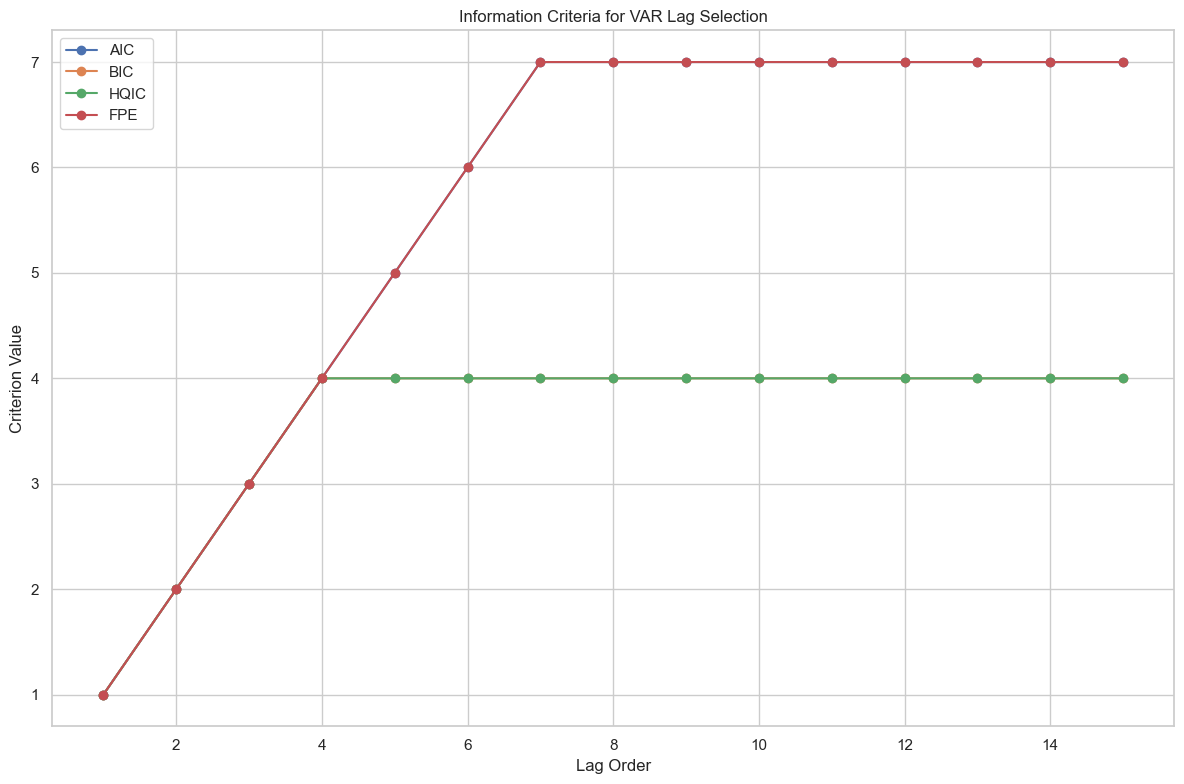

In [539]:
# Function to select optimal lag order
def select_var_order(data, max_lags=5):
    # Create a VAR model
    model = VAR(data)
    
    # Determine information criteria for different lag orders
    results = {}
    for i in range(1, max_lags + 1):
        results[i] = model.select_order(i)
    
    # Create a DataFrame to display the results
    criteria = ['aic', 'bic', 'hqic', 'fpe']
    order_df = pd.DataFrame(index=range(1, max_lags + 1), columns=criteria)
    
    for i in range(1, max_lags + 1):
        for criterion in criteria:
            order_df.loc[i, criterion] = getattr(results[i], criterion)
    
    return order_df

# Select optimal lag order
lag_order_results = select_var_order(train_df[["y2", "y10"]], max_lags=15)
print("Information criteria for different lag orders:")
print(lag_order_results)

# Plot the information criteria
plt.figure(figsize=(12, 8))
for column in lag_order_results.columns:
    plt.plot(lag_order_results.index, lag_order_results[column], marker='o', label=column.upper())
plt.xlabel('Lag Order')
plt.ylabel('Criterion Value')
plt.title('Information Criteria for VAR Lag Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This results indicate us that we should choose 4 or 7 lags, we will start with 4 lags to make the model more simple

### 2.1. Johansen Test

In [540]:
# Perform Johansen test
# K=4 in levels VAR -> k_ar_diff = K-1 = 3 lags in VECM differences
# ecdet = "const" -> det_order = 0 (constant in CE)
data_for_test = train_df[['y2', 'y10']]
johansen_result = coint_johansen(data_for_test, det_order=0, k_ar_diff=6)

print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (99%): {johansen_result.cvt[i, 1]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1'] # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (99%): {johansen_result.cvm[i, 1]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")


--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 86.976
  Critical Value (99%): 15.494
  Result: Reject H0 at 5% significance level.
H0: r <= 1
  Trace Statistic: 4.181
  Critical Value (99%): 3.841
  Result: Reject H0 at 5% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 82.796
  Critical Value (99%): 14.264
  Result: Reject H0 at 5% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 4.181
  Critical Value (99%): 3.841
  Result: Reject H0 at 5% significance level.


With a cofidence interval of 95% we have evidence to reject both H0 for r=0 (or r<=0) and  H0 for r=1 (or r<=1), meaning that we have **TWO cointegration vectors**

In [541]:
print("Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):")
print(johansen_result.evec)

# First cointegrating vector (raw)
print("\nCointegrating Vector 1 (beta - first column of eigenvectors):")
coint_vector_1_raw = johansen_result.evec[:, 0]
print(coint_vector_1_raw)

# Normalize the first element to 1 for easier interpretation
coint_vector_1_normalized = coint_vector_1_raw / coint_vector_1_raw[0]
print("\nCointegrating Vector 1 (beta, normalized with first coefficient = 1):")
print(coint_vector_1_normalized)

# Second cointegrating vector (raw)
print("\nCointegrating Vector 2 (beta - second column of eigenvectors):")
coint_vector_2_raw = johansen_result.evec[:, 1]
print(coint_vector_2_raw)

# Normalize the first element of the second vector to 1 as well
coint_vector_2_normalized = coint_vector_2_raw / coint_vector_2_raw[0]
print("\nCointegrating Vector 2 (beta, normalized with first coefficient = 1):")
print(coint_vector_2_normalized)

Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):
[[ 56.60970726  -3.4158727 ]
 [-28.30801983   1.69602707]]

Cointegrating Vector 1 (beta - first column of eigenvectors):
[ 56.60970726 -28.30801983]

Cointegrating Vector 1 (beta, normalized with first coefficient = 1):
[ 1.         -0.50005593]

Cointegrating Vector 2 (beta - second column of eigenvectors):
[-3.4158727   1.69602707]

Cointegrating Vector 2 (beta, normalized with first coefficient = 1):
[ 1.         -0.49651355]


### 2.2. VECM model estimation

In [565]:
# Estimate VECM
vecm_model = VECM(data_for_test, k_ar_diff=3, coint_rank=2, deterministic='ci', freq= 'D')
vecm_results = vecm_model.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation y2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y2         -2.0849      1.560     -1.336      0.181      -5.143       0.973
L1.y10         1.6260      0.778      2.091      0.037       0.102       3.150
L2.y2         -1.0170      1.290     -0.788      0.430      -3.545       1.511
L2.y10         0.2447      0.644      0.380      0.704      -1.018       1.507
L3.y2         -0.3210      0.904     -0.355      0.722      -2.092       1.450
L3.y10         0.2679      0.454      0.591      0.555      -0.621       1.157
Det. terms outside the coint. relation & lagged endog. parameters for equation y10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y2         -4.3250      3.132     -1.381  

In [543]:
print("\nCointegrating Vector (beta) from VECM results:")
# Note: statsmodels VECM beta might be scaled differently than R's urca.
# The interpretation depends on the normalization.
print(vecm_results.beta)

# Let's normalize the first element to 1 for comparison with previous result
beta_normalized_vecm = vecm_results.beta[:, 0] / vecm_results.beta[0, 0]
print("\nCointegrating Vector (beta, normalized with ppi=1):")
print(beta_normalized_vecm)

print("\nAdjustment Coefficients (alpha) from VECM results:")
print(vecm_results.alpha)


Cointegrating Vector (beta) from VECM results:
[[ 1.00000000e+00 -5.21578657e-15]
 [ 2.62424245e-15  1.00000000e+00]]

Cointegrating Vector (beta, normalized with ppi=1):
[1.00000000e+00 2.62424245e-15]

Adjustment Coefficients (alpha) from VECM results:
[[ 4.74966711 -2.376269  ]
 [11.65487458 -5.83038865]]


### 2.3 Impulse Response Function (IRF)

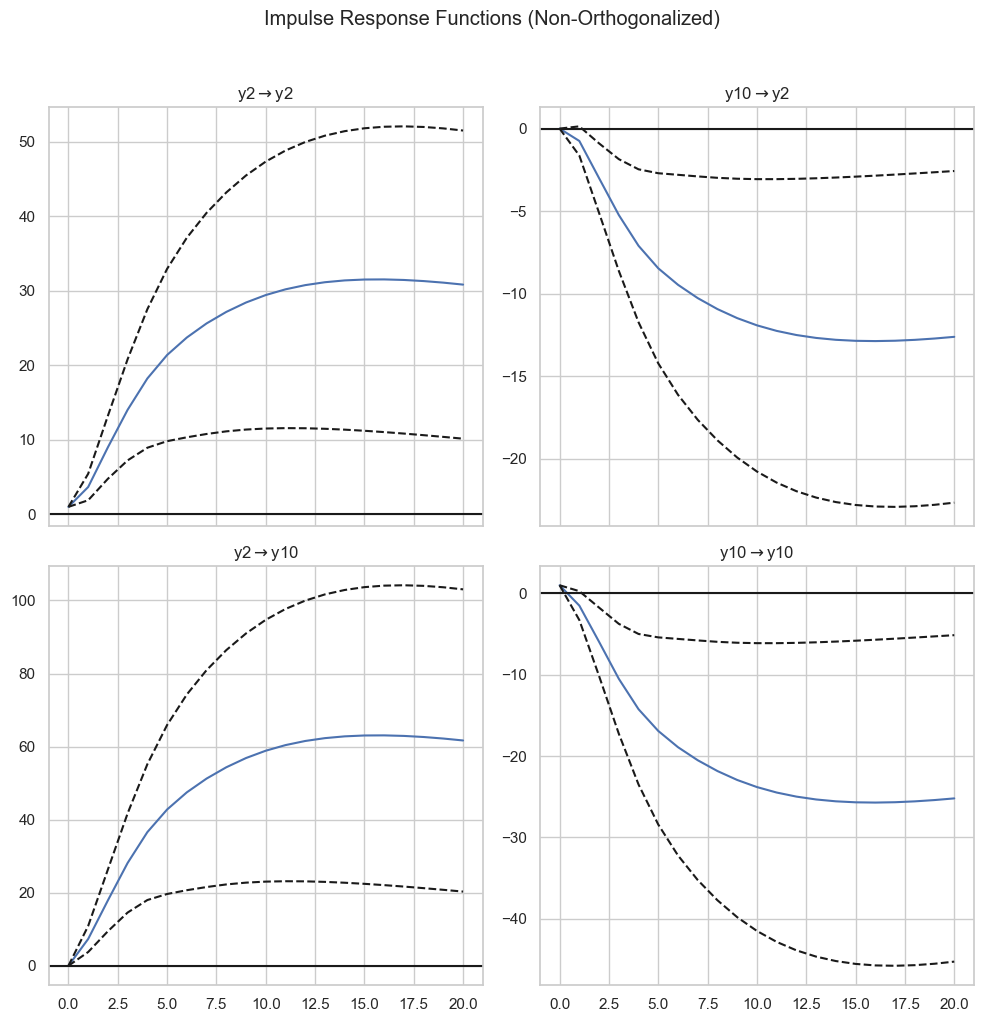

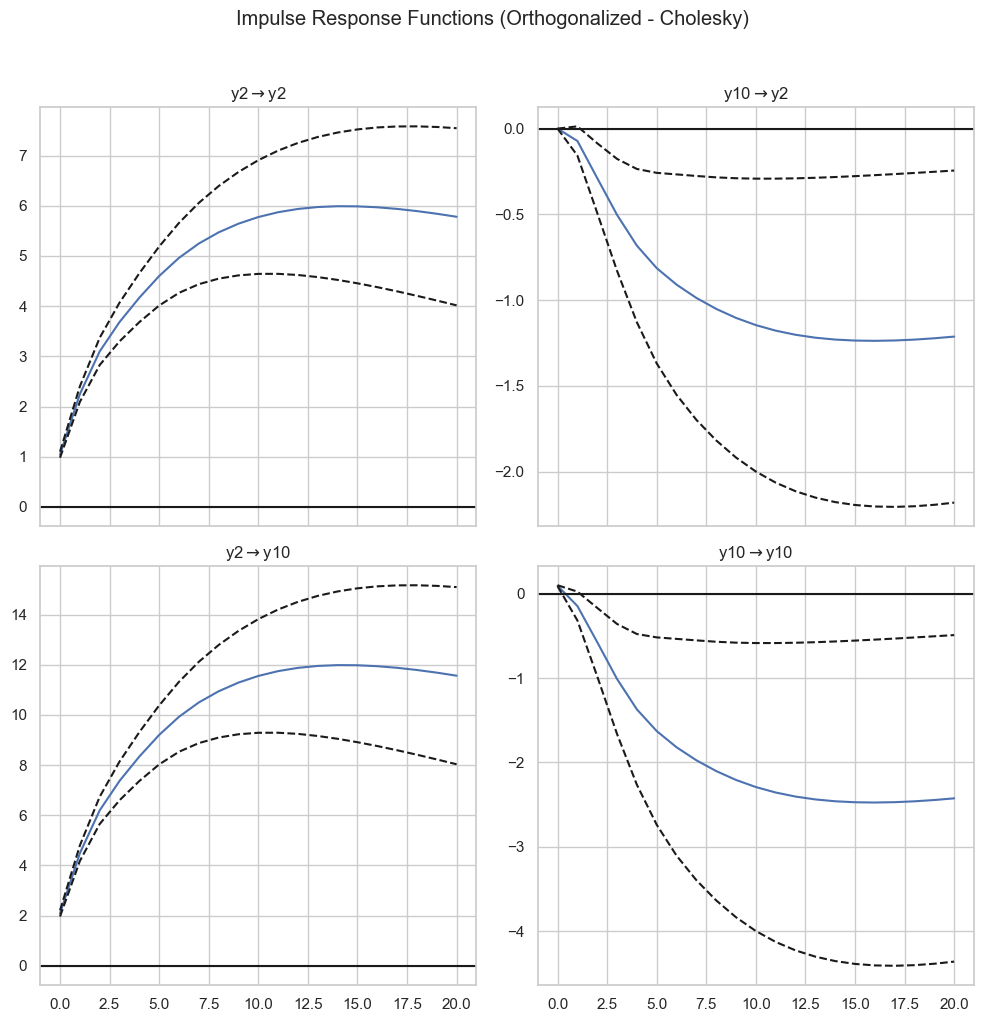

In [544]:
# Calculate and plot IRFs
irf = vecm_results.irf(periods=20)

# Non-orthogonalized IRFs
irf.plot(orth=False)
plt.suptitle('Impulse Response Functions (Non-Orthogonalized)', y=1.02)
plt.tight_layout()
plt.show()

# Orthogonalized IRFs (using Cholesky decomposition by default)
irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (Orthogonalized - Cholesky)', y=1.02)
plt.tight_layout()
plt.show()

We can see persinten effect in both variables shocks, this can be evidence for a bi-directional causuality

### 2.4. Variance Decompostion

In [545]:
# Estimate VAR
var_model = VAR(data_for_test)
var_results = var_model.fit(4)

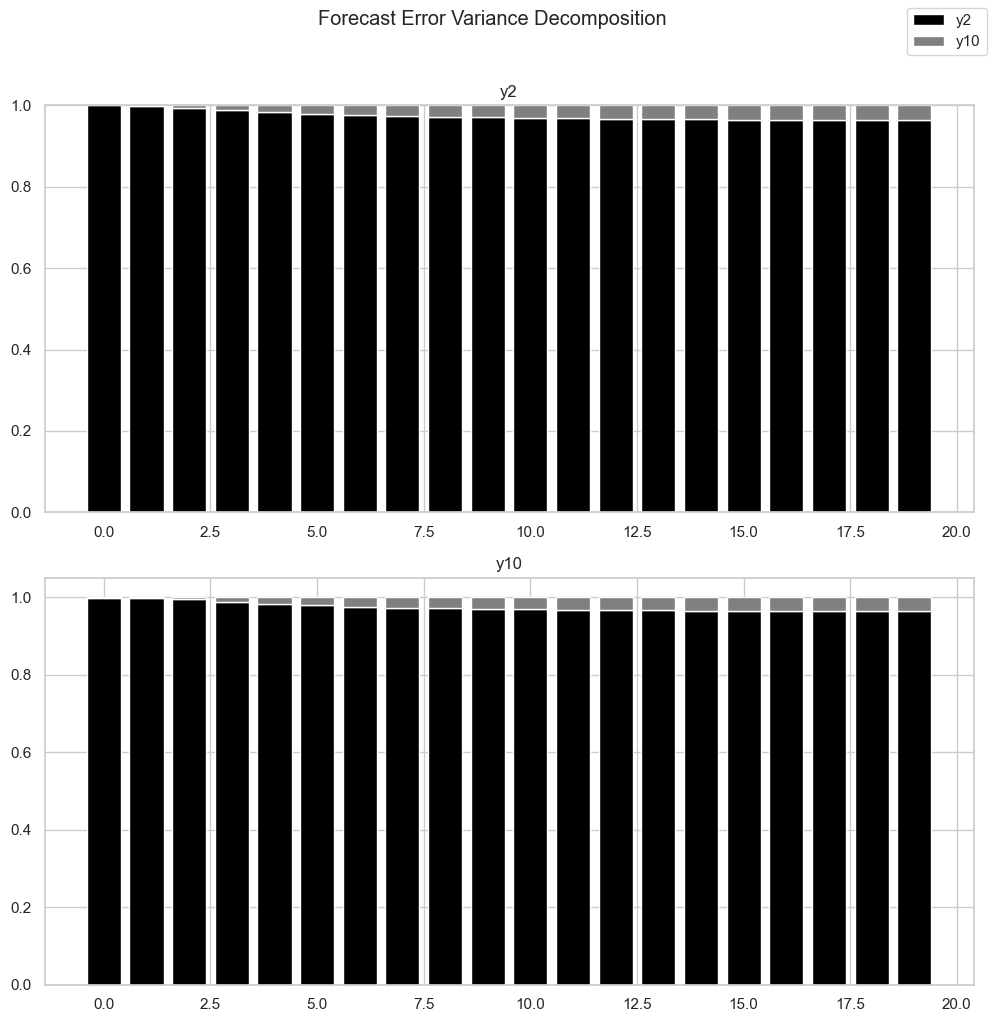


FEVD Summary (Period 20):
FEVD for y2
            y2       y10
0     1.000000  0.000000
1     0.999150  0.000850
2     0.994394  0.005606
3     0.988457  0.011543
4     0.982980  0.017020
5     0.978784  0.021216
6     0.975745  0.024255
7     0.973446  0.026554
8     0.971622  0.028378
9     0.970126  0.029874
10    0.968877  0.031123
11    0.967822  0.032178
12    0.966923  0.033077
13    0.966149  0.033851
14    0.965480  0.034520
15    0.964897  0.035103
16    0.964385  0.035615
17    0.963934  0.036066
18    0.963535  0.036465
19    0.963179  0.036821

FEVD for y10
            y2       y10
0     0.997875  0.002125
1     0.998766  0.001234
2     0.994320  0.005680
3     0.988349  0.011651
4     0.982834  0.017166
5     0.978680  0.021320
6     0.975666  0.024334
7     0.973388  0.026612
8     0.971578  0.028422
9     0.970090  0.029910
10    0.968847  0.031153
11    0.967796  0.032204
12    0.966900  0.033100
13    0.966129  0.033871
14    0.965462  0.034538
15    0.964880  0.0351

In [546]:
# Calculate and plot FEVD
fevd = var_results.fevd(periods=20)
fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition', y=1.02)
plt.tight_layout()
plt.show()

# Print FEVD summary for the last period
print("\nFEVD Summary (Period 20):")
print(fevd.summary())

In this case we can see how the biggest part of the variance of y2 comes from itself, however for y10 the most comes from y2

In [547]:
residuals = vecm_results.resid
# to DataFrame
residuals = pd.DataFrame(residuals, columns=['y2', 'y10'], index=train_df.index[4:])
print("Residuals (first 5 rows):")
print(residuals.head())

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals (lag=10):")
ljung_box_y2 = acorr_ljungbox(residuals['y2'], lags=[10], return_df=True)
ljung_box_y10 = acorr_ljungbox(residuals['y10'], lags=[10], return_df=True)
print("y2 Residuals:\n", ljung_box_y2)
print("\ny10 Residuals:\n", ljung_box_y10)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_y2['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y2 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y2 residuals.")
if ljung_box_y10['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y10 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y10 residuals.")

Residuals (first 5 rows):
                      y2           y10
date                                  
2023-09-13 -0.4613820582 -1.1193171528
2023-09-14  1.6405246037  3.2866866303
2023-09-15 -0.2196970559 -0.5509469711
2023-09-16  0.3492759820  0.8151316006
2023-09-17  1.3480591484  2.6119940948

Ljung-Box Test for Serial Correlation in Residuals (lag=10):
y2 Residuals:
          lb_stat    lb_pvalue
10 28.7690096154 0.0013579430

y10 Residuals:
          lb_stat    lb_pvalue
10 28.3186373588 0.0016048331

Conclusion at alpha=0.05:
 - Reject H0 (no serial correlation) for y2 residuals.
 - Reject H0 (no serial correlation) for y10 residuals.


The null hypothesis of no serial correlation is rejected for both residual series, indicating potential model misspecification (e.g., incorrect lag order or omitted variables). We may try VECM with 7 lags as we had evidence proviously

Before changing the number of residuals lets analyze ACF and PACF 

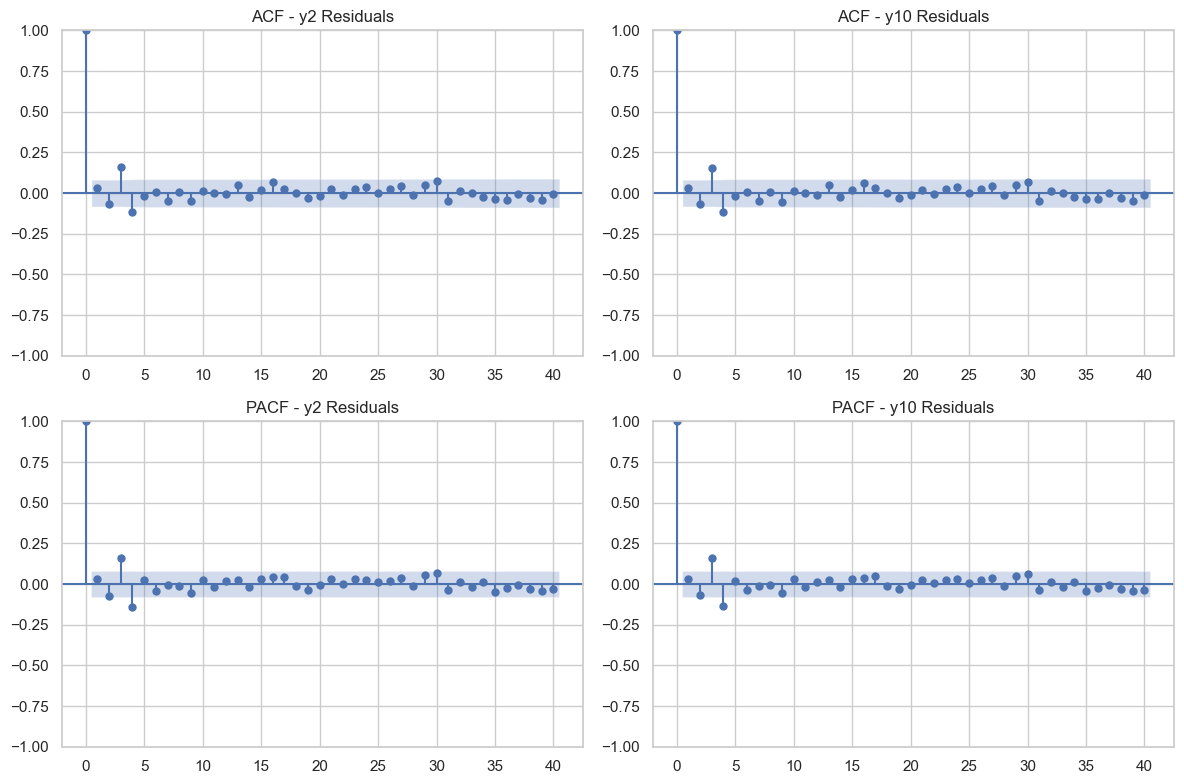

In [548]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals['y2'], ax=axes[0, 0], title='ACF - y2 Residuals', lags=40)
plot_pacf(residuals['y2'], ax=axes[1, 0], title='PACF - y2 Residuals', lags=40, method='ywm') # 'ols' method might fail if near non-stationarity
plot_acf(residuals['y10'], ax=axes[0, 1], title='ACF - y10 Residuals', lags=40)
plot_pacf(residuals['y10'], ax=axes[1, 1], title='PACF - y10 Residuals', lags=40, method='ywm')
plt.tight_layout()
plt.show()

Third and forth residuals are significant, lets try with 7 lags.

In [549]:
# Estimate VECM
vecm_model = VECM(data_for_test, k_ar_diff=6, coint_rank=2, deterministic='ci', freq= 'D')
vecm_results = vecm_model.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation y2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y2         -2.9676      2.223     -1.335      0.182      -7.325       1.390
L1.y10         2.1013      1.110      1.893      0.058      -0.074       4.276
L2.y2         -2.5961      2.014     -1.289      0.197      -6.543       1.351
L2.y10         0.9508      1.006      0.945      0.345      -1.022       2.923
L3.y2         -0.9758      1.777     -0.549      0.583      -4.458       2.506
L3.y10         0.7491      0.887      0.845      0.398      -0.989       2.487
L4.y2         -1.4868      1.528     -0.973      0.331      -4.482       1.508
L4.y10         0.5487      0.763      0.719      0.472      -0.947       2.045
L5.y2         -1.5619      1.264     -1.236      0.217      -4.039       0.916
L5.y10         0.9131      0.631      1.447      

In [550]:
print("\nCointegrating Vector (beta) from VECM results:")
# Note: statsmodels VECM beta might be scaled differently than R's urca.
# The interpretation depends on the normalization.
print(vecm_results.beta)

# Let's normalize the first element to 1 for comparison with previous result
beta_normalized_vecm = vecm_results.beta[:, 0] / vecm_results.beta[0, 0]
print("\nCointegrating Vector (beta, normalized with ppi=1):")
print(beta_normalized_vecm)

print("\nAdjustment Coefficients (alpha) from VECM results:")
print(vecm_results.alpha)


Cointegrating Vector (beta) from VECM results:
[[1.00000000e+00 2.72744768e-14]
 [5.77672069e-15 1.00000000e+00]]

Cointegrating Vector (beta, normalized with ppi=1):
[1.00000000e+00 5.77672069e-15]

Adjustment Coefficients (alpha) from VECM results:
[[ 5.73672399 -2.86969653]
 [13.58555284 -6.79554327]]


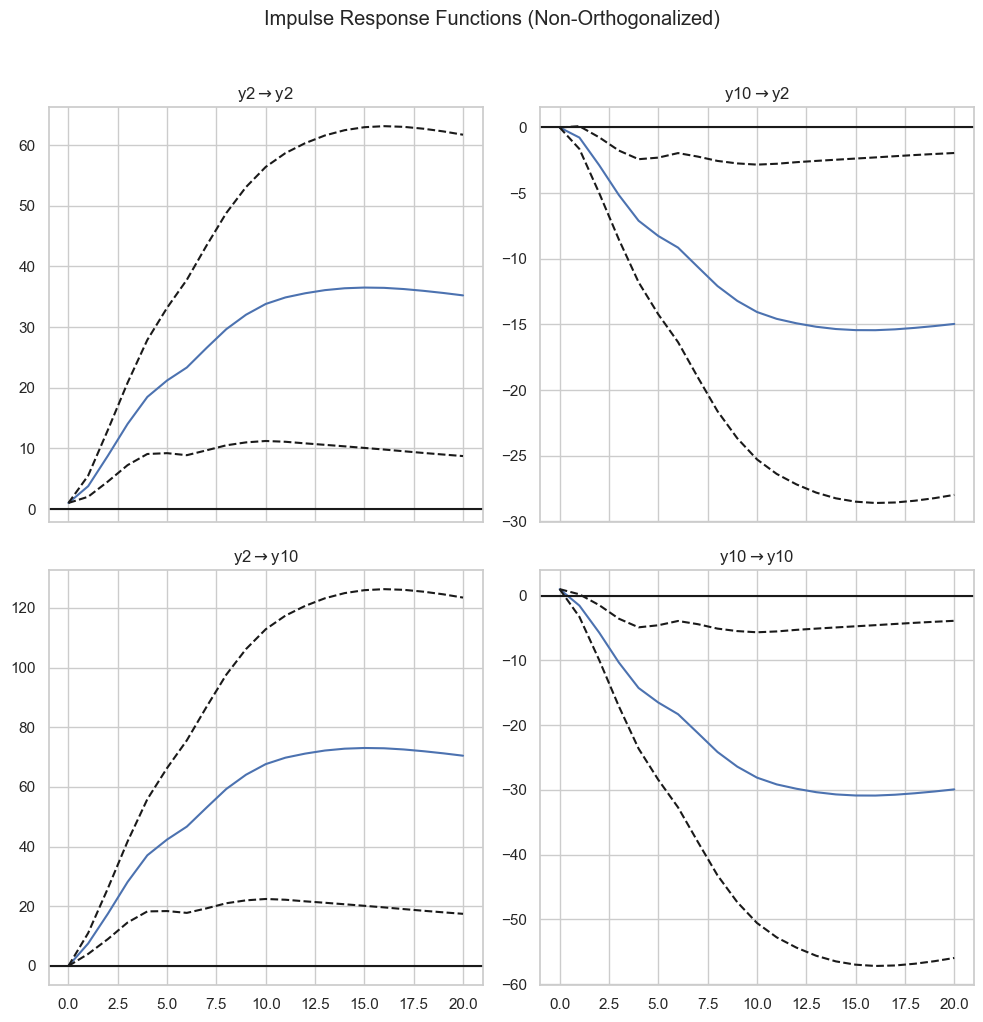

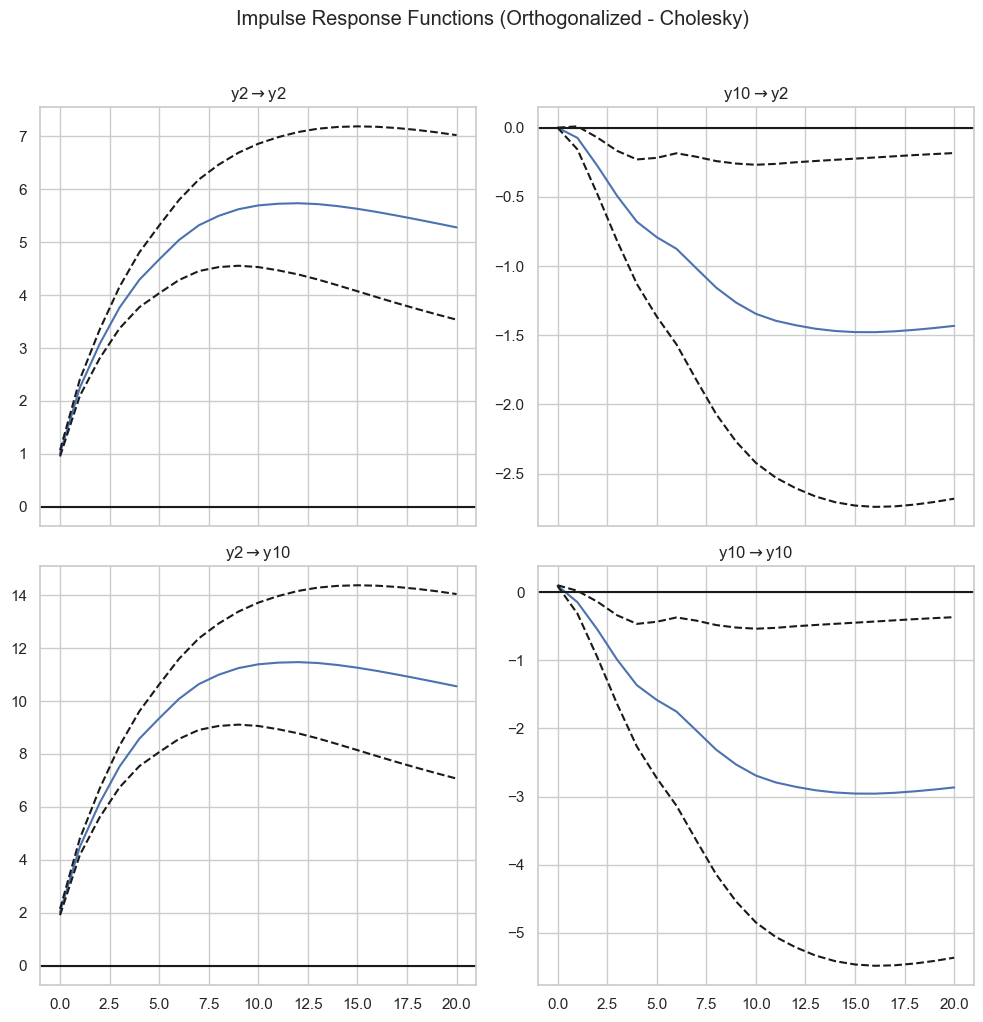

In [551]:
# Calculate and plot IRFs
irf = vecm_results.irf(periods=20)

# Non-orthogonalized IRFs
irf.plot(orth=False)
plt.suptitle('Impulse Response Functions (Non-Orthogonalized)', y=1.02)
plt.tight_layout()
plt.show()

# Orthogonalized IRFs (using Cholesky decomposition by default)
irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (Orthogonalized - Cholesky)', y=1.02)
plt.tight_layout()
plt.show()

In [552]:
# Estimate VAR
var7_model = VAR(data_for_test)
var7_results = var_model.fit(7)

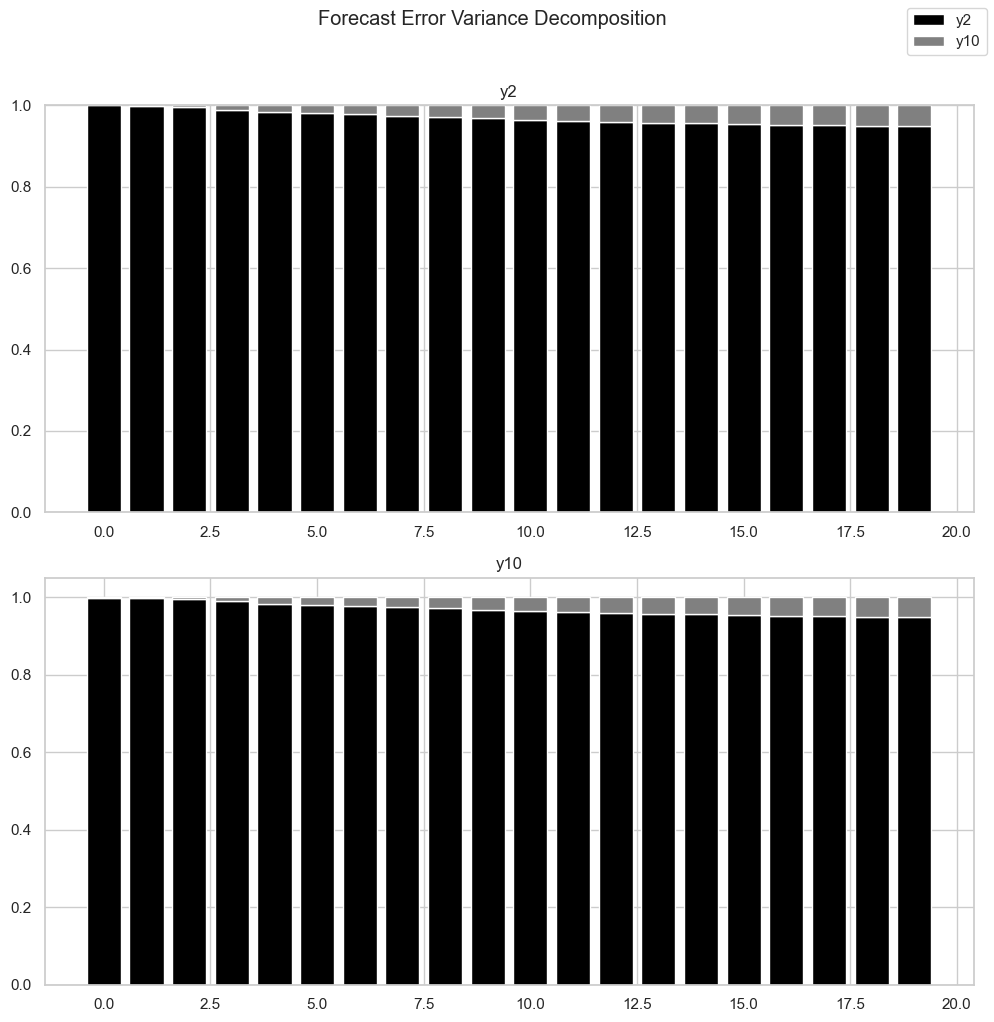


FEVD Summary (Period 20):
FEVD for y2
            y2       y10
0     1.000000  0.000000
1     0.999113  0.000887
2     0.994840  0.005160
3     0.989238  0.010762
4     0.983933  0.016067
5     0.980216  0.019784
6     0.977657  0.022343
7     0.974669  0.025331
8     0.971274  0.028726
9     0.967912  0.032088
10    0.964758  0.035242
11    0.961981  0.038019
12    0.959576  0.040424
13    0.957444  0.042556
14    0.955538  0.044462
15    0.953839  0.046161
16    0.952327  0.047673
17    0.950989  0.049011
18    0.949806  0.050194
19    0.948757  0.051243

FEVD for y10
            y2       y10
0     0.997776  0.002224
1     0.998734  0.001266
2     0.994748  0.005252
3     0.989120  0.010880
4     0.983778  0.016222
5     0.980130  0.019870
6     0.977586  0.022414
7     0.974639  0.025361
8     0.971253  0.028747
9     0.967895  0.032105
10    0.964743  0.035257
11    0.961966  0.038034
12    0.959563  0.040437
13    0.957431  0.042569
14    0.955527  0.044473
15    0.953828  0.0461

In [553]:

# Calculate and plot FEVD
fevd = var7_results.fevd(periods=20)
fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition', y=1.02)
plt.tight_layout()
plt.show()

# Print FEVD summary for the last period
print("\nFEVD Summary (Period 20):")
print(fevd.summary())

### Autocorrelation and Normality of residuals

In [554]:
residuals = vecm_results.resid
# to DataFrame
residuals = pd.DataFrame(residuals, columns=['y2', 'y10'], index=train_df.index[7:])
print("Residuals (first 5 rows):")
print(residuals.head())

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals (lag=10):")
ljung_box_y2 = acorr_ljungbox(residuals['y2'], lags=[10], return_df=True)
ljung_box_y10 = acorr_ljungbox(residuals['y10'], lags=[10], return_df=True)
print("y2 Residuals:\n", ljung_box_y2)
print("\ny10 Residuals:\n", ljung_box_y10)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_y2['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y2 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y2 residuals.")
if ljung_box_y10['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y10 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y10 residuals.")

Residuals (first 5 rows):
                      y2           y10
date                                  
2023-09-16  0.5375284854  1.1897224825
2023-09-17  0.9648194771  1.8455317413
2023-09-18  0.5762579125  1.2063199586
2023-09-19 -1.0664137421 -1.9822338505
2023-09-20  0.9447349601  2.0480661621

Ljung-Box Test for Serial Correlation in Residuals (lag=10):
y2 Residuals:
         lb_stat    lb_pvalue
10 4.0051431819 0.9471146663

y10 Residuals:
         lb_stat    lb_pvalue
10 4.3433542422 0.9305312926

Conclusion at alpha=0.05:
 - Cannot reject H0 (no serial correlation) for y2 residuals.
 - Cannot reject H0 (no serial correlation) for y10 residuals.


Now we can reject serial correlation for both residuals series, it seems that 7 lags fits better

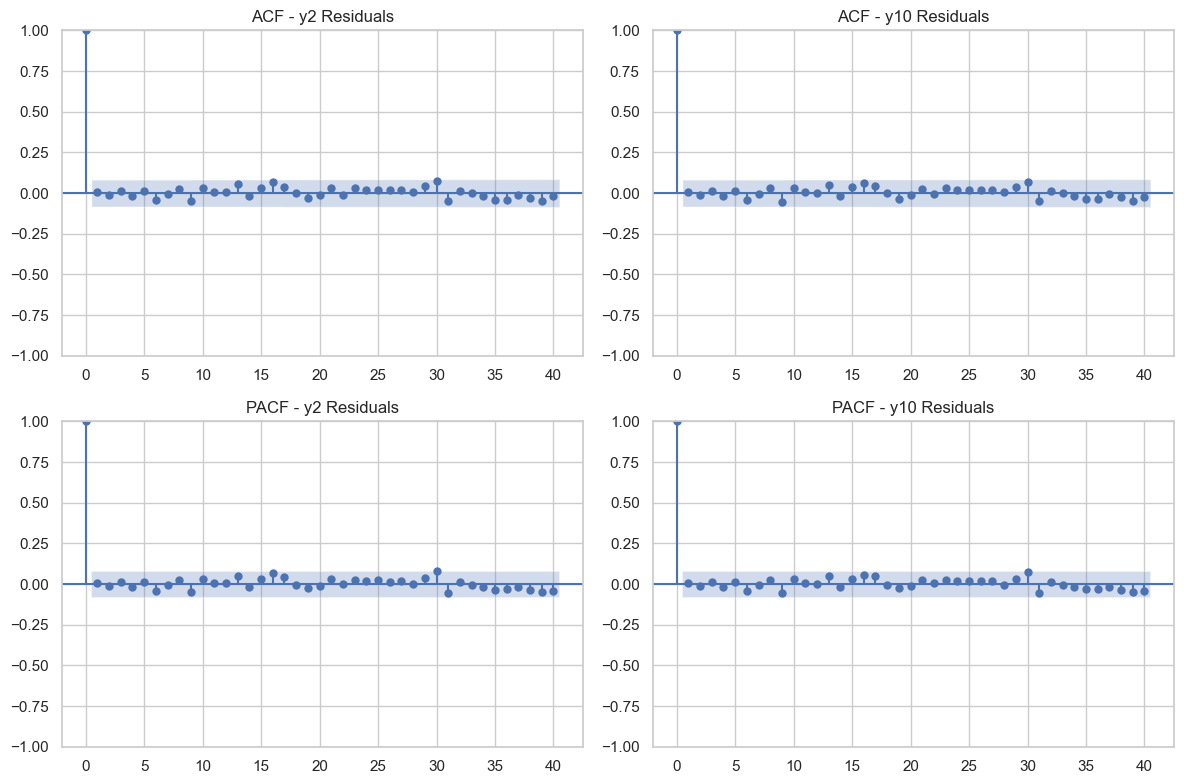

In [555]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals['y2'], ax=axes[0, 0], title='ACF - y2 Residuals', lags=40)
plot_pacf(residuals['y2'], ax=axes[1, 0], title='PACF - y2 Residuals', lags=40, method='ywm') # 'ols' method might fail if near non-stationarity
plot_acf(residuals['y10'], ax=axes[0, 1], title='ACF - y10 Residuals', lags=40)
plot_pacf(residuals['y10'], ax=axes[1, 1], title='PACF - y10 Residuals', lags=40, method='ywm')
plt.tight_layout()
plt.show()

We eliminate all the significant residuals, once again it seems that our model works better with 7 lags.

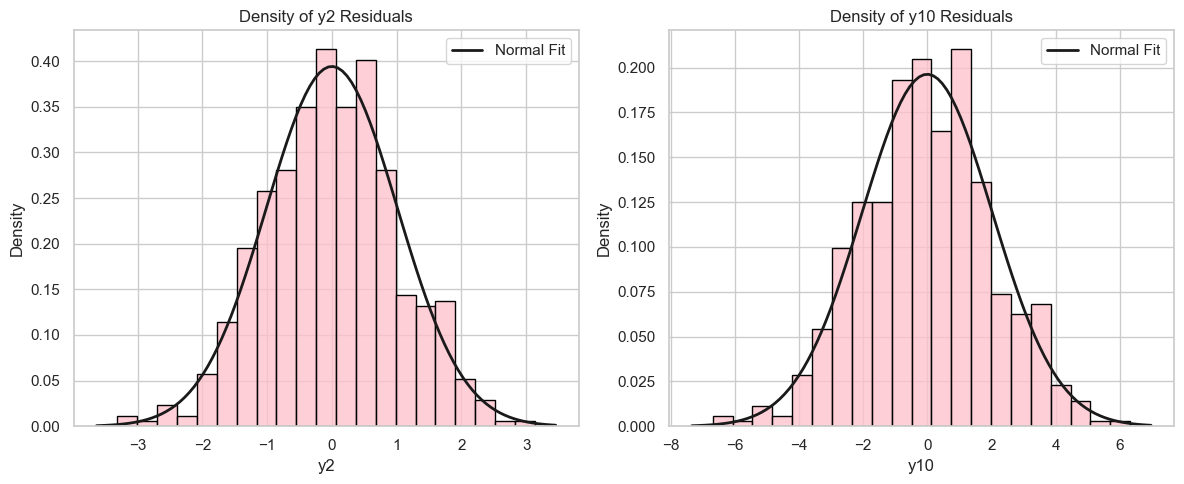

In [556]:
# Plot histograms of residuals with normal density overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals['y2'], kde=False, stat='density', ax=axes[0], color='pink', edgecolor='black')
axes[0].set_title('Density of y2 Residuals')
# Overlay normal distribution
mu_y2, std_y2 = residuals['y2'].mean(), residuals['y2'].std()
xmin_y2, xmax_y2 = axes[0].get_xlim()
x_y2 = np.linspace(xmin_y2, xmax_y2, 100)
p_y2 = norm.pdf(x_y2, mu_y2, std_y2)
axes[0].plot(x_y2, p_y2, 'k', linewidth=2, label='Normal Fit')
axes[0].legend()

sns.histplot(residuals['y10'], kde=False, stat='density', ax=axes[1], color='pink', edgecolor='black')
axes[1].set_title('Density of y10 Residuals')
# Overlay normal distribution
mu_y10, std_y10 = residuals['y10'].mean(), residuals['y10'].std()
xmin_y10, xmax_y10 = axes[1].get_xlim()
x_y10 = np.linspace(xmin_y10, xmax_y10, 100)
p_y10 = norm.pdf(x_y10, mu_y10, std_y10)
axes[1].plot(x_y10, p_y10, 'k', linewidth=2, label='Normal Fit')
axes[1].legend()

plt.tight_layout()
plt.show()

It seems that the residuals are normally distributed, lets check on Jarque-Bera test

In [557]:
# Test for normality (Jarque-Bera test)
jb_y2_stat, jb_y2_pval, _, _ = jarque_bera(residuals['y2'])
jb_y10_stat, jb_y10_pval, _, _ = jarque_bera(residuals['y10'])

print("\nJarque-Bera Normality Test for Residuals:")
print(f"y2 Residuals: Statistic={jb_y2_stat:.3f}, p-value={jb_y2_pval:.3f}")
print(f"y10 Residuals: Statistic={jb_y10_stat:.3f}, p-value={jb_y10_pval:.3f}")

alpha_norm = 0.05
print(f"\nConclusion at alpha={alpha_norm}:")
if jb_y2_pval < alpha_norm:
    print(" - Reject normality for y2 residuals.")
else:
    print(" - Cannot reject normality for y2 residuals.")
if jb_y10_pval < alpha_norm:
    print(" - Reject normality for y10 residuals.")
else:
    print(" - Cannot reject normality for y10 residuals.")

# Multivariate Normality Test (using VECMResults method)
try:
    normality_test_results = vecm_results.test_normality()
    print("\nMultivariate Normality Test Results (using VECMResults method):")
    print(normality_test_results)
except Exception as e:
    print(f"\nCould not run multivariate normality test directly: {e}")


Jarque-Bera Normality Test for Residuals:
y2 Residuals: Statistic=0.195, p-value=0.907
y10 Residuals: Statistic=0.162, p-value=0.922

Conclusion at alpha=0.05:
 - Cannot reject normality for y2 residuals.
 - Cannot reject normality for y10 residuals.

Multivariate Normality Test Results (using VECMResults method):
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 2.189, critical value: 9.488>, p-value: 0.701>


In the same line with the plot,wWe dont have evidence to reject that the residuals are normally distributed.

### Forecasting with VECM

In [558]:
# Re-estimate VECM on shorter sample
vecm_model_short = VECM(train_df[["y2", "y10"]], k_ar_diff=6, coint_rank=2, deterministic='ci', freq="D")
vecm_results_short = vecm_model_short.fit()

# Generate forecasts
forecast_values = vecm_results_short.predict(steps=25)
forecast_intervals = vecm_results_short.predict(steps=25, alpha=0.05) # alpha=0.05 for 95% CI

# Create forecast DataFrame
forecast_index = test_df.index
forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['y2_fore', 'y10_fore'])

print(forecast_df)

                  y2_fore       y10_fore
date                                    
2025-04-06 160.0905777409 220.7955619809
2025-04-07 158.9082673714 218.4181591212
2025-04-08 157.9622790082 216.5172232315
2025-04-09 157.1980051258 214.9878351378
2025-04-10 156.8813527589 214.3592386914
2025-04-11 156.6531640575 213.9021093183
2025-04-12 156.4622281959 213.5220975502
2025-04-13 156.4535123938 213.5037869425
2025-04-14 156.5494377356 213.6955729973
2025-04-15 156.7421182962 214.0811260416
2025-04-16 157.0411835328 214.6796473781
2025-04-17 157.3864964895 215.3706798738
2025-04-18 157.7673386849 216.1323834622
2025-04-19 158.1856760894 216.9693002380
2025-04-20 158.6231527165 217.8443841752
2025-04-21 159.0761938035 218.7505944001
2025-04-22 159.5414337807 219.6812063488
2025-04-23 160.0094043454 220.6171858640
2025-04-24 160.4778390944 221.5540716942
2025-04-25 160.9453616536 222.4891095033
2025-04-26 161.4089703923 223.4163031574
2025-04-27 161.8680107177 224.3343511078
2025-04-28 162.3

In [559]:
# Create forecast interval DataFrames
forecast_lower = pd.DataFrame(forecast_intervals[1], index=forecast_index, columns=['y2_lower', 'y10_lower'])
forecast_upper = pd.DataFrame(forecast_intervals[2], index=forecast_index, columns=['y2_upper', 'y10_upper'])

# Combine forecasts and intervals
forecast_combined = pd.concat([forecast_df, forecast_lower, forecast_upper], axis=1)
print("\nForecasts and Confidence Intervals:")
print(forecast_combined)


Forecasts and Confidence Intervals:
                  y2_fore       y10_fore       y2_lower      y10_lower  \
date                                                                     
2025-04-06 160.0905777409 220.7955619809 158.1090508063 216.8161731939   
2025-04-07 158.9082673714 218.4181591212 154.0674552646 208.7449293419   
2025-04-08 157.9622790082 216.5172232315 150.2109790913 201.0240788803   
2025-04-09 157.1980051258 214.9878351378 146.4551649261 193.5121495145   
2025-04-10 156.8813527589 214.3592386914 143.1760856425 186.9579819061   
2025-04-11 156.6531640575 213.9021093183 140.0960151581 180.7964369116   
2025-04-12 156.4622281959 213.5220975502 137.1061560258 174.8166220975   
2025-04-13 156.4535123938 213.5037869425 134.3794193675 169.3603392759   
2025-04-14 156.5494377356 213.6955729973 131.8833156354 164.3669248297   
2025-04-15 156.7421182962 214.0811260416 129.6138381773 159.8274753159   
2025-04-16 157.0411835328 214.6796473781 127.5894618935 155.7788573825   
2

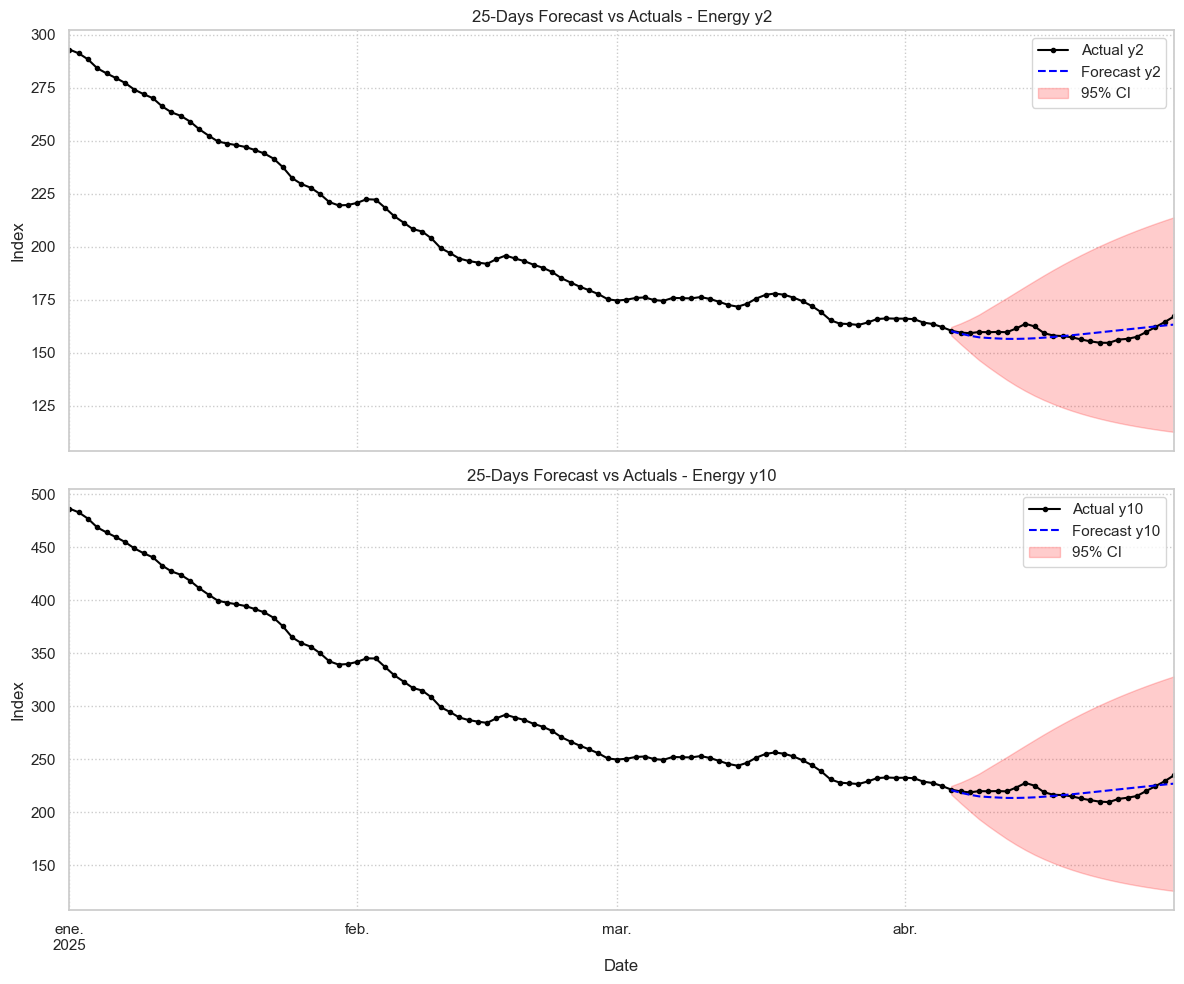

In [563]:
# Merge forecasts with the original data for plotting
df_merged = df.merge(forecast_combined, left_index=True, right_index=True, how='left')

# Plot forecasts vs actuals
plot_start_date = '2025-01-01' # Start date for the plot window

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# y2 Plot
df_merged.loc[plot_start_date:, 'y2'].plot(ax=axes[0], label='Actual y2', color='black', marker='.')
df_merged.loc[plot_start_date:, 'y2_fore'].plot(ax=axes[0], label='Forecast y2', color='blue', linestyle='--')
axes[0].fill_between(df_merged.loc[plot_start_date:].index, # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'y2_lower'],
                     df_merged.loc[plot_start_date:, 'y2_upper'], color='red', alpha=0.2, label='95% CI')
axes[0].set_title('25-Days Forecast vs Actuals - Energy y2')
axes[0].set_ylabel('Index')
axes[0].legend()
axes[0].grid(True, linestyle=':')

# y10 Plot
df_merged.loc[plot_start_date:, 'y10'].plot(ax=axes[1], label='Actual y10', color='black', marker='.')
df_merged.loc[plot_start_date:, 'y10_fore'].plot(ax=axes[1], label='Forecast y10', color='blue', linestyle='--')
axes[1].fill_between(df_merged.loc[plot_start_date:].index, # Ensure index alignment
                       df_merged.loc[plot_start_date:, 'y10_lower'],
                       df_merged.loc[plot_start_date:, 'y10_upper'], color='red', alpha=0.2, label='95% CI')
axes[1].set_title('25-Days Forecast vs Actuals - Energy y10')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Index')
axes[1].legend()
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()

### VECM error metrics

In [509]:
# Define the function for MAPE and AMAPE
def mape(actual, pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / actual)) * 100

def amape(actual, pred):
    """Adjusted/Symmetric Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / ((actual + pred) / 2))) * 100

# Calculate metrics for y2
y2_mae = mean_absolute_error(test_df['y2'], forecast_df['y2_fore'])
y2_mse = mean_squared_error(test_df['y2'], forecast_df['y2_fore'])
y2_rmse = np.sqrt(y2_mse)
y2_mape = mape(test_df['y2'], forecast_df['y2_fore'])
y2_amape = amape(test_df['y2'], forecast_df['y2_fore'])

# Calculate metrics for y10
y10_mae = mean_absolute_error(test_df['y10'], forecast_df['y10_fore'])
y10_mse = mean_squared_error(test_df['y10'], forecast_df['y10_fore'])
y10_rmse = np.sqrt(y10_mse)
y10_mape = mape(test_df['y10'], forecast_df['y10_fore'])
y10_amape = amape(test_df['y10'], forecast_df['y10_fore'])

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'y2': [y2_mae, y2_mse, y2_rmse, y2_mape, y2_amape],
    'y10': [y10_mae, y10_mse, y10_rmse, y10_mape, y10_amape]
}, index=['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'AMAPE (%)'])

print("Forecast Accuracy Metrics:")
print(metrics_df)


Forecast Accuracy Metrics:
                     y2           y10
MAE        2.8805148270  5.7427420016
MSE       11.8563506868 47.0820096928
RMSE       3.4433051980  6.8616331651
MAPE (%)   1.8103323314  2.6254835332
AMAPE (%)  1.8118399600  2.6276982909
